# ARIMA Model Fitting and Training

## Library

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
import itertools
from pmdarima import auto_arima
import statsmodels.api as sm

from col_eda import close_d_org, close_d, close_w, close_m

### Check data stationary

In [35]:
# From decomposition, we can see that the data has positive trend and seasonality. it is not stationary. 
def check_stationary(df):
    result = adfuller(df.diff().dropna())
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    print(result)
    
    # Decision based on p-value
    if p_value < 0.05:
        print(f"The p-value {p_value} is less than 0.05. We reject the null hypothesis. The time series is likely stationary.")
    else:
        print(f"The p-value {p_value} is greater than 0.05. We fail to reject the null hypothesis. The time series is likely non-stationary.")

    # Additional decision logic based on ADF statistic and critical values
    print("Based on the ADF Statistic and critical values:")
    if adf_statistic < critical_values['1%']:
        print("- The series is stationary with 99% confidence.")
    elif adf_statistic < critical_values['5%']:
        print("- The series is stationary with 95% confidence.")
    elif adf_statistic < critical_values['10%']:
        print("- The series is stationary with 90% confidence.")
    else:
        print("- The series is not stationary.")
        

In [46]:
print('close_d_org')
check_stationary(close_d_org)
print('\nclose_d')
check_stationary(close_d)
print('\nclose_w')
check_stationary(close_w)
print('\nclose_m')
check_stationary(close_m)

close_d_org
(-10.545115383241619, 8.452430710497291e-19, 11, 1300, {'1%': -3.435390199468821, '5%': -2.8637658312426035, '10%': -2.567955046745562}, -308.9021316688486)
The p-value 8.452430710497291e-19 is less than 0.05. We reject the null hypothesis. The time series is likely stationary.
Based on the ADF Statistic and critical values:
- The series is stationary with 99% confidence.

close_d
(-9.55196795524411, 2.5575963535382577e-16, 19, 1877, {'1%': -3.433838687021998, '5%': -2.863081058653235, '10%': -2.567590403056488}, -1147.040980613176)
The p-value 2.5575963535382577e-16 is less than 0.05. We reject the null hypothesis. The time series is likely stationary.
Based on the ADF Statistic and critical values:
- The series is stationary with 99% confidence.

close_w
(-17.32057784511083, 5.4846317951647954e-30, 0, 270, {'1%': -3.4548039258751206, '5%': -2.872304928618605, '10%': -2.5725063100137175}, 319.06585015923247)
The p-value 5.4846317951647954e-30 is less than 0.05. We reject t

In [ ]:
# split train test set

In [69]:
def train_test(df):
    test_start_date = '2023-07-31'
    train = df[:test_start_date]
    test = df[test_start_date:]
    return train, test

In [70]:
train, test = train_test(close_d)
train.shape

(1714, 1)

In [71]:
model = auto_arima(train, seasonal=True, random_state=42)
result = model.fit(train)
predictions = model.predict(n_periods=len(test))
# Summarize the best model
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1714
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 469.512
Date:                Sun, 03 Mar 2024   AIC                           -937.023
Time:                        19:37:02   BIC                           -931.577
Sample:                    11-21-2018   HQIC                          -935.008
                         - 07-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0338      0.000     76.034      0.000       0.033       0.035
Ljung-Box (L1) (Q):                   2.66   Jarque-Bera (JB):              9637.23
Prob(Q):                              0.10   Pr

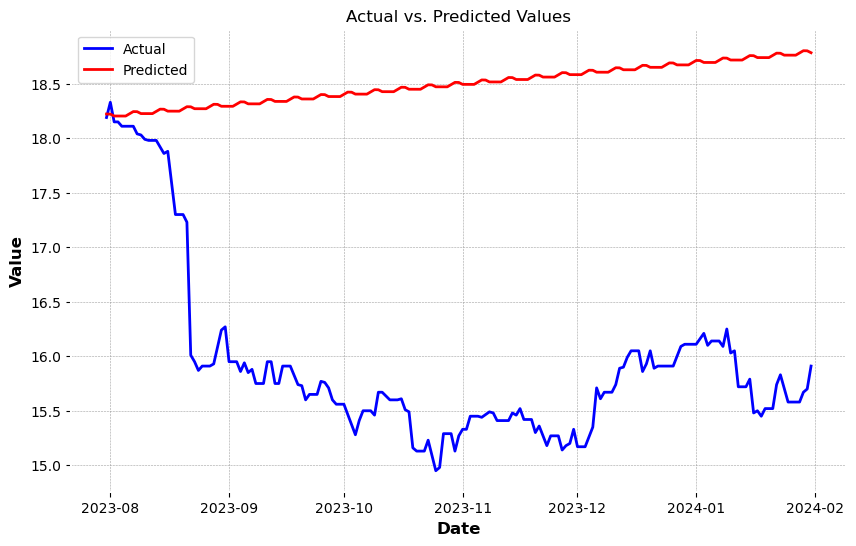

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
p_value = d_value = q_value = range(0, 5)  
P_value = D_value = Q_value = range(0, 5)
seasonal_period = 7

best_aic = np.inf
best_params = None

for p, d, q in itertools.product(p_value, d_value, q_value):
    for P, D, Q in itertools.product(P_value, D_value, Q_value):
        try:
            # Fit SARIMA model
            model = sm.tsa.SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))
            results = model.fit()

            # Evaluate model
            aic = results.aic

            # Check if current model has lower AIC than the best model found so far
            if aic < best_aic:
                best_aic = aic
                best_params = (p, d, q, P, D, Q)

        except:
            continue

# Fit final model with the best parameters

if best_params is not None:
    final_model = sm.tsa.SARIMAX(train, order=(best_params[0], best_params[1], best_params[2]),
                                  seasonal_order=(best_params[3], best_params[4], best_params[5], seasonal_period))
    final_results = final_model.fit()

    # Print the summary of the final model
    print(final_results.summary())
else:
    print("No suitable model found during grid search.")

No suitable model found during grid search.


In [85]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Example for a seasonal time series
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
fit_model = model.fit()
predictions = fit_model.forecast(len(test))

In [87]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - predictions) / test)) * 100

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Absolute Error (MAE): 2.5779764042791466
Mean Squared Error (MSE): 7.424639210690931
Root Mean Squared Error (RMSE): 2.724819115224152
Mean Absolute Percentage Error (MAPE): nan%


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Data should be transformed to 3D shape for LSTM [samples, timesteps, features]
# Model definition
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)